In [1]:
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
#-- This block is only required on Google Colab
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/MyDrive/glq_mpia'
#--
import contrastive_utils

/content/drive/MyDrive/glq_mpia


In [2]:
fl = np.load('./data/processed/ids.npz')
ids = fl['ids']
fl = np.load("./data/processed/imgs.npz")
imgs = fl["imgs"]

In [3]:
# Loading model
contrastor = contrastive_utils.Contrastor(
    contrastive_utils.load_augmentor(),
    contrastive_utils.load_encoder(n_filters_1=128, n_filters_2=256, n_filters_3=512),
    contrastive_utils.load_projector(input_size=512, n_nodes_1=256, n_nodes_3=128),
    temperature=0.1,
)
# Compiling model
contrastor.compile(
    optimizer=optimizers.SGD(learning_rate=3e-4, momentum=1e-5), run_eagerly=True
)

In [4]:
# Training model
history = contrastor.fit(
    contrastive_utils.normalise_imgs(imgs),
    batch_size=128,
    epochs=100,
    callbacks=[EarlyStopping(
        monitor="loss",
        mode="min",
        patience=5,
        verbose=1,
        min_delta=0.01
    )],
)
contrastor.save_weights('./models/contrastor', save_format='tf')

Epoch 1/100


55/55 [==============================] - 20s 153ms/step - loss: 5.6540
Epoch 2/100
55/55 [==============================] - 7s 136ms/step - loss: 5.5323
Epoch 3/100
55/55 [==============================] - 8s 140ms/step - loss: 5.5009
Epoch 4/100
55/55 [==============================] - 9s 159ms/step - loss: 5.4668
Epoch 5/100
55/55 [==============================] - 7s 136ms/step - loss: 5.3099
Epoch 6/100
55/55 [==============================] - 8s 151ms/step - loss: 4.7674
Epoch 7/100
55/55 [==============================] - 8s 151ms/step - loss: 4.3037
Epoch 8/100
55/55 [==============================] - 8s 143ms/step - loss: 3.9260
Epoch 9/100
55/55 [==============================] - 8s 153ms/step - loss: 3.6771
Epoch 10/100
55/55 [==============================] - 8s 142ms/step - loss: 3.6007
Epoch 11/100
55/55 [==============================] - 8s 150ms/step - loss: 3.5124
Epoch 12/100
55/55 [==============================] - 9s 155ms/step - loss: 3.4286
Epoch 13/100
55/55 [====

In [5]:
# Forward passing the original images
encoded_imgs = contrastor.encoder(
    contrastive_utils.normalise_imgs(imgs[:, 2:-2, 2:-2, :])
).numpy()
encoded_imgs = np.array([enc_img / np.linalg.norm(enc_img) for enc_img in encoded_imgs])
np.savez_compressed('./data/processed/encoded_imgs', ids=ids, encoded_imgs=encoded_imgs)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
fl = np.load('./data/processed/encoded_imgs.npz')
ids = fl['ids']
enc_imgs = fl['encoded_imgs']
hzq_df = pd.read_csv('./data/external/known_hzqs.csv')
hzq_cois = [coi for coi in hzq_df['COADD_OBJECT_ID']
           if str(coi) in ids]

In [29]:
embedding = TSNE(n_components=2, perplexity=10).fit_transform(enc_imgs)

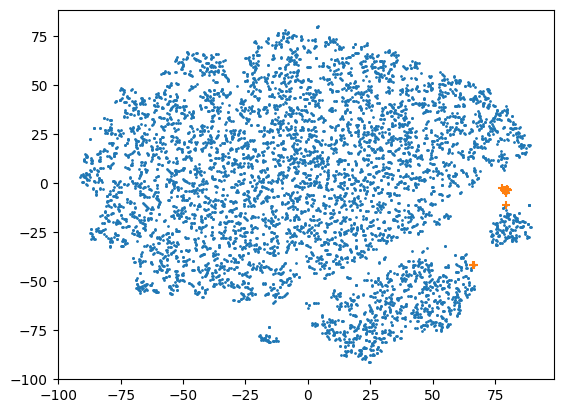

In [30]:
plt.scatter(
    embedding[:,0], embedding[:,1], s=1
)
plt.scatter(
    [embedding[ids.astype(int)==coi,0] for coi in hzq_cois],
    [embedding[ids.astype(int)==coi,1] for coi in hzq_cois],
    marker='+'
)

(-15.0, 0.0)

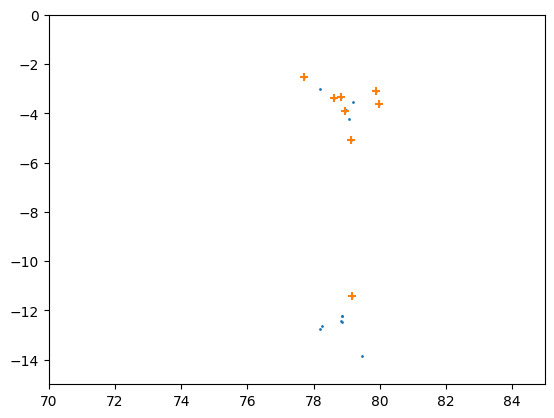

In [31]:
plt.scatter(
    embedding[:,0], embedding[:,1], s=1
)
plt.scatter(
    [embedding[ids.astype(int)==coi,0] for coi in hzq_cois],
    [embedding[ids.astype(int)==coi,1] for coi in hzq_cois],
    marker='+'
)
plt.xlim(70,85) # These limits may need to
plt.ylim(-15,0) # be adjusted

In [40]:
quasar_ids = ids[
    (76<embedding[:,0])
    &(embedding[:,0]<82)
    &(-6<embedding[:,1])
    &(embedding[:,1]<0)
]
np.savez_compressed(
    './data/processed/quasar_ids.npz',
    ids=quasar_ids
)
print(quasar_ids)

['1228745162' '1413280997' '1695974542' '1143273115' '1456016600'
 '1599741416' '1096344653' '1513805078' '1271696125' '1197311621'
 '1250552714']
